# Inclusão Financeira na Africa
---

## IMPORTS

In [50]:
import pickle
import warnings

import numpy                    as np
import pandas                   as pd

import seaborn                  as sns
import matplotlib.pyplot        as plt
from dataprep.eda               import create_report, plot_diff

from scipy                      import stats     
from typing                     import Union
from IPython.core.display       import HTML

from yellowbrick.features       import Rank1D, Rank2D

from boruta                     import BorutaPy
from imblearn.combine           import SMOTETomek 
from imblearn.over_sampling     import SMOTENC

from xgboost                    import XGBClassifier
from lightgbm                   import LGBMClassifier
from catboost                   import CatBoostClassifier

import optuna
from optuna.integration         import LightGBMPruningCallback

from sklearn.feature_selection  import RFE
from sklearn.naive_bayes        import GaussianNB
from sklearn.metrics            import roc_auc_score, log_loss, precision_score, recall_score, f1_score
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.preprocessing      import MinMaxScaler
from sklearn.model_selection    import train_test_split, StratifiedKFold
from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier


## HELPER FUNCTIONS

### Metrics

In [51]:
def categorical_metrics(data: Union[int, str], col: str):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    
    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })

In [52]:
def numerical_metrics(numerical_attributes: Union[int, float]):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25))).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75))).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns = ['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes

### Plots

In [53]:
def correlation_ascending(data: Union[int, float, str], col: str, method: str):
    """Generates a correlation matrix of each numerical variables in ascending order.

    Args:
        data ([dataFrame]): [The dataframe of the EDA]
        col ([object]): [The column selected]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """

    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    correlation = num_attributes.corr(method = method)

    correlation_asc = correlation[col].sort_values(ascending=False).to_frame()
    correlation_asc.columns = ['']
    correlation_asc.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( correlation_asc, annot=True, cmap='rocket').set_title(col);
    
    return plot

In [54]:
def correlation_matrix(data: Union[int, float], cols_drop: str, method: str):
    """Generates a correlation matrix of numerical variables

    Args:
        data ([DataFrame]): [The dataframe of the EDA]
        cols_drop ([list]): [Cols to drop]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    num_attributes = num_attributes.drop(columns = cols_drop )
    correlation = num_attributes.corr(method = method)

    # plot
    ax = sns.heatmap(correlation, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return ax

In [55]:
def cramers_v(categorical_attributes: Union[str, int]):
    """Calculates Cramer's V

    Args:
        categorical_attributes ([DataFrame]): [The dataframe with all categorical features]


    Returns:
        [Dict]: [Dictionary with cramer's V]
    """

    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            cm = pd.crosstab(categorical_attributes[ref], categorical_attributes[feat]).to_numpy()
            n = cm.sum()
            r, k = cm.shape
            chi2 = stats.chi2_contingency(cm)[0]
            chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
            kcorr = k - (k-1)**2/(n-1)
            rcorr = r - (r-1)**2/(n-1)
            corr = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
            corr_list.append(corr)
        
        corr_dict[ref]= corr_list
    
    return corr_dict

In [56]:
def highlight_max(s):
    # Only apply highlight in int and float
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: #F15854' if cell else '' for cell in is_max]

In [57]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('tableau-colorblind10')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [58]:
def multiple_histplots(data: Union[int, float, str], rows: int, cols: int):
    """
    Shows a matrix with hisplots of selected features.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with histplots]
    """

    for i, col in enumerate(data.columns, 1):
        plt.subplot(rows, cols, i)
        ax = sns.histplot(data[col], kde = True)
        plt.ylabel('')
        plt.style.use('tableau-colorblind10')

    return ax

In [59]:
def percentage(ax,data: Union[str, int, float]):
    """Shows percentage in countplots

    Args:
        ax: [Variable name of the plot]
        data ([DataFrame]): [Dataframe of the countplot]


    Returns:
        [Dict]: [Dictionary with cramer's V]
    """

    for p in ax.patches:
        height = p.get_height()
        len_data = len(data)
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height/len_data*100),
                ha="center")

In [60]:
def plot_with_target(target_x: Union[int, float, str], target_y: Union[int, float, str], col: str, position_x: int, position_y: int, label_x: str, label_y: str):
    """
    Create some histplots with target feature.

    Args:
        target_x ([dataframe]): [Dataframe with all numerical features and positive target]
        target_y ([dataframe]): [Dataframe with all numerical features and negative target]
        col ([str]): [Name of the feature of the plot]
        position_x ([int]): [Position in the subplot]
        position_y ([int]): [Position in the subplot]
        label_x ([str]): [Name of the label of negative target]
        label_y ([str]): [Name of the label of positive target]

    Returns:
        [Image]: [Histplots of all features with target]
    """

    plt.style.use('tableau-colorblind10')
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label = label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label = label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax

In [61]:
def confusion_matrix(model): 
    
    """
    Creates a confusion matrix plot with churn and not churn using yellowbrick.

    Args:
        model: [The Machine Learning algorithm utilized]

    Returns:
        [Image]: [The confusion matrix plot]
    """


    confusion_matrix = ConfusionMatrix(model, classes = ['no', 'yes'], cmap = 'PuBu')
    confusion_matrix.fit(X_train, y_train)  
    confusion_matrix.score(X_test, y_test)  
    ax = confusion_matrix.finalize()

    return ax

### Models

In [62]:
def cross_validation(models, target: str, X_train: Union[int, float, str], y_train: Union[int, float, str], kfold: int = 5, verbose: bool = True):
    """Return CV result
    
    Args:
        model: [ML model for CV]
        target[str]: [Target feature name]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        kfold[int]: [Number of data splits]
        k[int] = [at_k value]
        verbose[bool]: [print folding]

    Returns:
        [DataFrame]: [Dataframe with Precision at K and Recall at K]
    """
    print('Please, wait a moment, Doing CV')
    folds = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 42)
    precision_list = []
    recall_list = []
    f1_list = []
    roc_auc_list = []

    model_df = []
    j = 1
    l = len(models)
    
    for model in models:
        model_name = type(model).__name__
        if verbose == True:
            print(f"Folding model {j}/{l} -> " + model_name)

        for train_cv, val_cv in folds.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]
            X_val_fold = X_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            # fit model
            model.fit(X_train_fold, y_train_fold)
            
            # predict probabilities
            yhat = model.predict(X_val_fold)

            data = X_val_fold.copy()
            data[target] = y_val_fold.copy()
            data['score'] = yhat.tolist()
            data = data.sort_values('score', ascending = False)

            # precision
            precision = precision_score(y_val_fold, yhat)
            precision_list.append(precision)

            # recall
            recall = recall_score(y_val_fold, yhat)
            recall_list.append(recall)
            
            # f1           
            f1 = f1_score(y_val_fold, yhat)
            f1_list.append(f1)
            
            # roc auc
            roc_auc = roc_auc_score(y_val_fold, yhat)
            roc_auc_list.append(roc_auc)


        df_result = pd.DataFrame({'Model_Name': (model_name),
                                  'Precision Mean': np.mean(precision_list).round(3),
                                  'Precision STD': np.std(precision_list).round(3),
                                  'Recall Mean': np.mean(recall_list).round(3),
                                  'Recall STD': np.std(recall_list).round(3),
                                  'F1 Mean': np.mean(f1_list).round(3),
                                  'F1 STD': np.std(f1_list).round(3),
                                  'ROCAUC Mean': np.mean(roc_auc_list).round(3),
                                  'ROCAUC STD': np.std(roc_auc_list).round(3)}, index = [0])
        
        j += 1

        model_df.append(df_result)
        cv_result = pd.concat(model_df)
    print('Finished, check the results')

    return cv_result

In [63]:
def metrics_result(models, target: str, X_train: Union[int, float, str], y_train: Union[int, float, str], X_val: Union[int, float, str], y_val: Union[int, float, str], verbose = True):
    """Return Metrics of the model
    
    Args:
        model: [ML model for CV]
        target[str]: [Target feature name]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        X_val[dataframe]: [Validation variables]
        y_val[list]: [Target feature list]
        k[int] = [at_k value]
        verbose[bool]: [print training]

    Returns:
        [DataFrame]: [Dataframe with Precision at K and Recall at K]
    """
    print('Please, wait a moment - Doing ML')
    model_df = []
    i = 1
    j = len(models)

    for model in models:
        model_name = type(model).__name__
        if verbose == True:
            print(f"Training model {i}/{j} -> " + model_name)
        model.fit(X_train, y_train)

        # probabilities prediction
        yhat = model.predict(X_val)

        # copy data
        data = X_val.copy()
        data[target] = y_val.copy()

        # propensity score
        data['score'] = yhat.tolist()

        # sort clients by propensity score
        data = data.sort_values('score', ascending = False)

        # precision
        precision = precision_score(y_val, yhat)

        # recall
        recall = recall_score(y_val, yhat)       
        
        # f1
        f1 = f1_score(y_val, yhat)       

        # roc auc
        roc_auc = roc_auc_score(y_val, yhat)

        i += 1

        df_result = pd.DataFrame({'Model_Name': model_name, 
                                  'Precision': precision,
                                  'Recall': recall,
                                  'F1 Score': f1,
                                  'ROCAUC': roc_auc}, index = [0])

        model_df.append(df_result)
        final_result = pd.concat(model_df)
    print('Finished, check the results')

    return final_result

### Hyperparameter Fine Tunning

In [64]:
def objective_lgbm(trial: int, X, y, splits: int = 5):
    """Apply parameters for Optuna bayesian search using logloss as metric
    Args:
        trial[int]: [Number of attempts to find the best result]
        X[Dataframe]: [Dataframe with all features except target]
        y[List]: [List with the target feature]
        splits[int]: [Number of splits for the StratifiedKfold n_splits]

    Returns:
        [str]: [Results Optuna]
    """
    
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000, step = 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step = 20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
                 }

    cv = StratifiedKFold(n_splits = splits, shuffle = True, random_state = 42)

    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        
        y_train, y_val = y[train_idx], y[val_idx]

        model = LGBMClassifier(objective = 'binary', **param_grid)
        model.fit(  X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'f1',
                    early_stopping_rounds = 50, callbacks = [LightGBMPruningCallback(trial, 'binary_logloss')]
                 )
        preds = model.predict_proba(X_val)
        cv_scores[idx] = log_loss(y_val, preds)

    return np.mean(cv_scores)

### Settings

In [65]:
# round
pd.options.display.float_format = '{:.3f}'.format

# ignoring errors
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

seed = 42

homepath = '/home/gutto/Repos/Hackdays/hackdays/'

## DATA

In [66]:
df_train = pd.read_csv(homepath + 'data/raw/train.csv', low_memory = False)
pickle.dump(df_train, open(homepath + 'data/processed/df_raw.pkl', 'wb'))

df_test = pd.read_csv(homepath + 'data/raw/test.csv', low_memory = False)
pickle.dump(df_test, open(homepath + 'data/processed/df_test.pkl', 'wb'))

## 1. DESCRIÇÃO DOS DADOS

### 1.1 Carregando Dados


In [67]:
df1 = pd.read_pickle(homepath + 'data/processed/df_raw.pkl')

In [68]:
df1.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,2016,uniqueid_4858,Rural,Yes,6,45,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,2017,uniqueid_3015,Urban,No,4,33,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,2016,uniqueid_103,Rural,Yes,7,43,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,2016,uniqueid_4582,Rural,No,6,35,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,2017,uniqueid_2854,Urban,Yes,2,30,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


### 1.2 Organizando Colunas 


In [69]:
df1 = df1.reindex(columns=['uniqueid', 'uid', 'country', 'year', 'gender_of_respondent', 'age_of_respondent','location_type', 'job_type', 'education_level', 'relationship_with_head', 'marital_status', 'household_size', 'cellphone_access', 'bank_account'])
df1.head()

,uniqueid,uid,country,year,gender_of_respondent,age_of_respondent,location_type,job_type,education_level,relationship_with_head,marital_status,household_size,cellphone_access,bank_account
0,uniqueid_4858,Rwanda_uniqueid_4858,Rwanda,2016,Male,45,Rural,Farming and Fishing,Primary education,Head of Household,Divorced/Seperated,6,Yes,No
1,uniqueid_3015,Tanzania_uniqueid_3015,Tanzania,2017,Female,33,Urban,Self employed,Primary education,Head of Household,Single/Never Married,4,No,No
2,uniqueid_103,Rwanda_uniqueid_103,Rwanda,2016,Male,43,Rural,Farming and Fishing,Secondary education,Head of Household,Married/Living together,7,Yes,No
3,uniqueid_4582,Rwanda_uniqueid_4582,Rwanda,2016,Female,35,Rural,Farming and Fishing,Primary education,Head of Household,Married/Living together,6,No,No
4,uniqueid_2854,Tanzania_uniqueid_2854,Tanzania,2017,Male,30,Urban,Informally employed,Primary education,Head of Household,Single/Never Married,2,Yes,No


### 1.3 Tamanho do Dataset


In [70]:
print(f'Número de linhas: {df1.shape[0]} \nNúmero de colunas: {df1.shape[1]}')


Número de linhas: 11762 
Número de colunas: 14


### 1.4 Verificação

In [71]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11762 entries, 0 to 11761
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniqueid                11762 non-null  object
 1   uid                     11762 non-null  object
 2   country                 11762 non-null  object
 3   year                    11762 non-null  int64 
 4   gender_of_respondent    11762 non-null  object
 5   age_of_respondent       11762 non-null  int64 
 6   location_type           11762 non-null  object
 7   job_type                11762 non-null  object
 8   education_level         11762 non-null  object
 9   relationship_with_head  11762 non-null  object
 10  marital_status          11762 non-null  object
 11  household_size          11762 non-null  int64 
 12  cellphone_access        11762 non-null  object
 13  bank_account            11762 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [72]:
df1.isna().sum()

uniqueid                  0
uid                       0
country                   0
year                      0
gender_of_respondent      0
age_of_respondent         0
location_type             0
job_type                  0
education_level           0
relationship_with_head    0
marital_status            0
household_size            0
cellphone_access          0
bank_account              0
dtype: int64

Esse banco de dados não possui NA

In [73]:
df1['bank_account'].value_counts(normalize = True)

No    0.857
Yes   0.143
Name: bank_account, dtype: float64

Algoritmos de Machine Learning para classificação binária consideram, geralmente, a variável resposta com uma proporção de 50-50, nesse caso a proporção é de 85,7-14,3.

**Um balanceamento será necessário!**

[Referência](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

### 1.5 Estatística Descritiva 

#### 1.5.1 Varíaveis Numéricas 

In [74]:
num_attributes = df1[['age_of_respondent', 'household_size']]
num_result = numerical_metrics(num_attributes)
num_result

,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,age_of_respondent,16.000,100.000,84.000,38.602,35.000,26.000,48.000,16.334,0.852,0.162
1,household_size,1.000,21.000,20.000,3.794,3.000,2.000,5.000,2.225,1.004,1.530


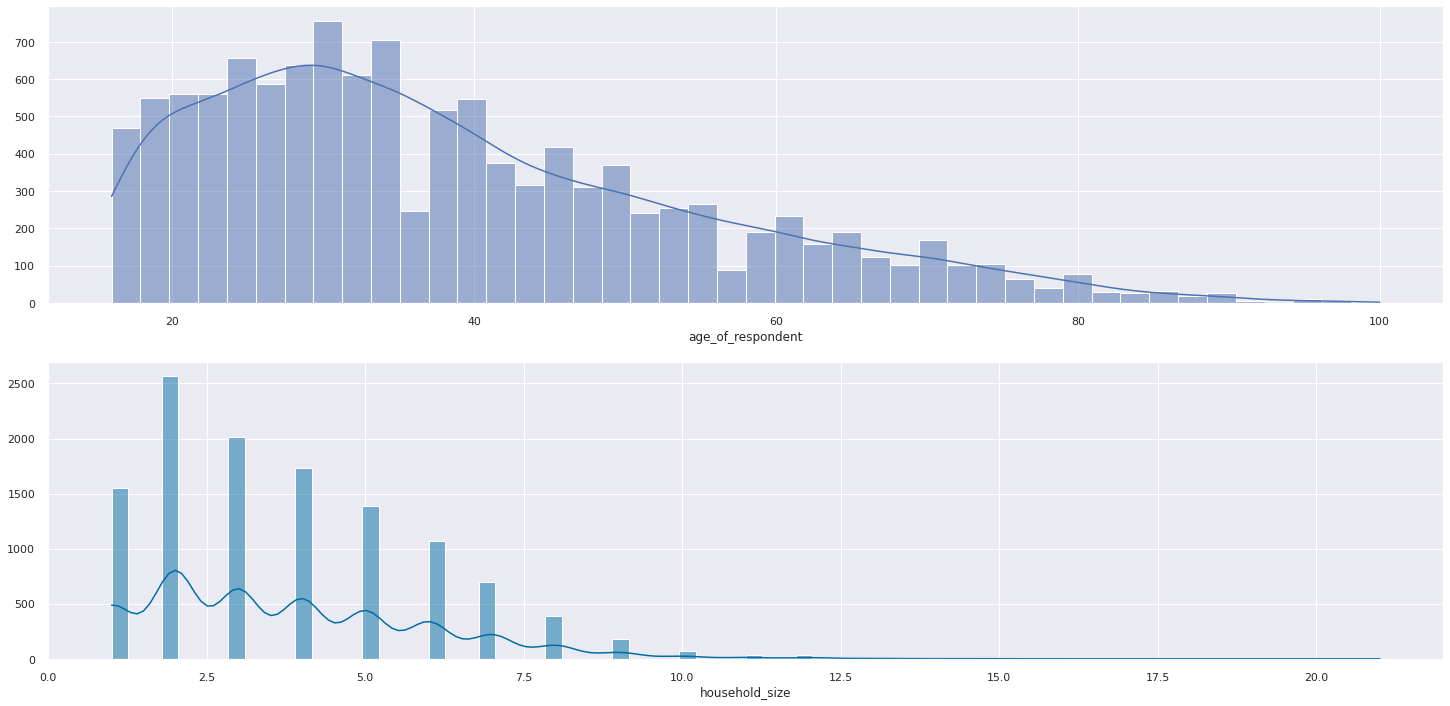

In [75]:
multiple_histplots(num_attributes, 2, 1);

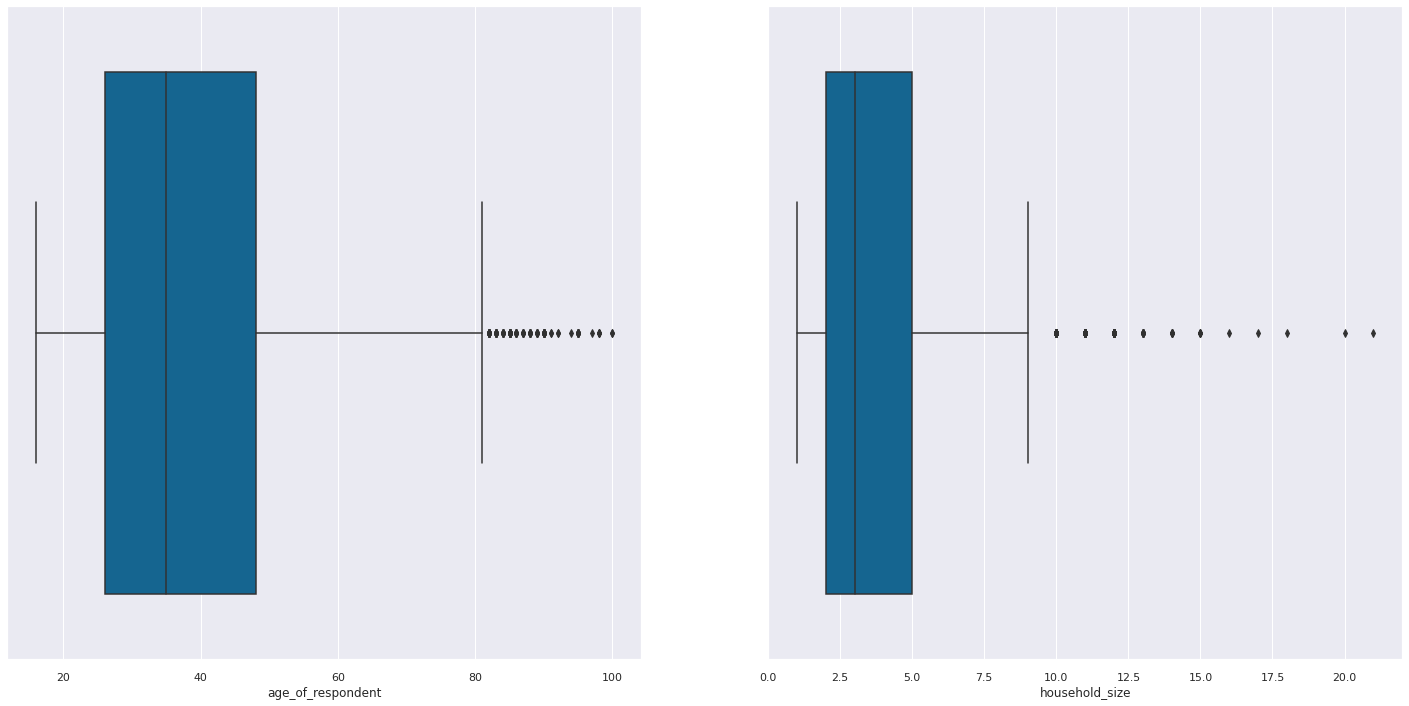

In [76]:
i = 1
for col in num_attributes:
    plt.subplot(1, 2, i)
    ax = sns.boxplot(data = num_attributes, x = col)
    i += 1

#### 1.5.2 Variáveis Categóricas 

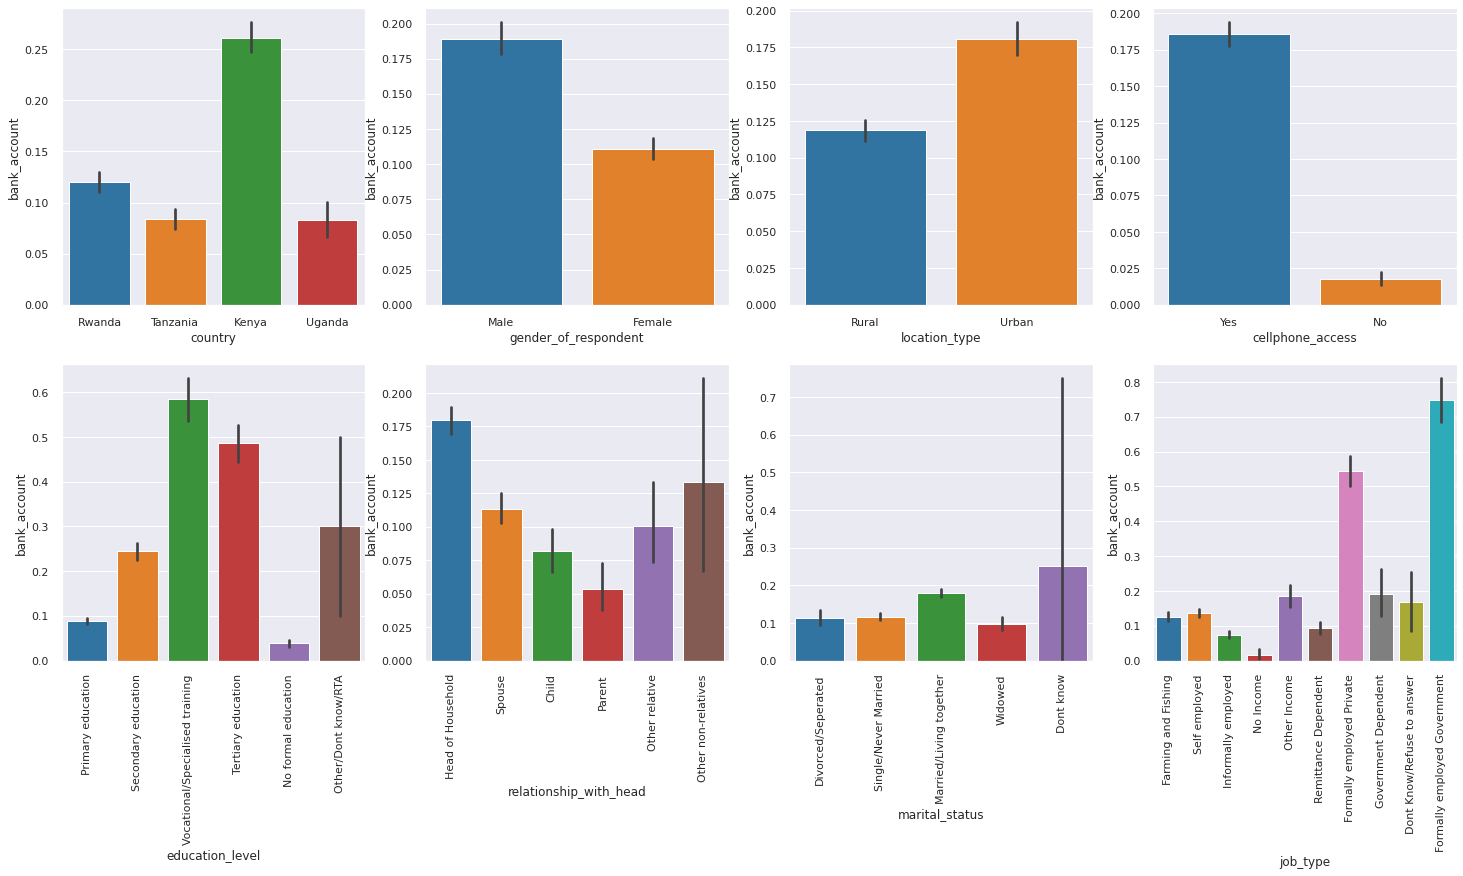

In [77]:
cat_attributes = df1[['country', 'gender_of_respondent','location_type', 'job_type', 'education_level', 'relationship_with_head', 'marital_status', 'cellphone_access', 'bank_account']]

basic_enc = {'No': 0, 'Yes': 1}
cat_attributes['bank_account'] = cat_attributes['bank_account'].map(basic_enc)

# creating subplots
fig, ax = plt.subplots()
#fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)

plt.subplot(2, 4, 1)
sns.barplot(x = 'country', y = 'bank_account', data = cat_attributes, palette = 'tab10');

plt.subplot(2, 4, 2)
sns.barplot(x = 'gender_of_respondent', y = 'bank_account', data = cat_attributes, palette = 'tab10');

plt.subplot(2, 4, 3)
sns.barplot(x = 'location_type', y = 'bank_account', data = cat_attributes, palette = 'tab10');

plt.subplot(2, 4, 4)
sns.barplot(x = 'cellphone_access', y = 'bank_account', data = cat_attributes, palette = 'tab10');

plt.subplot(2, 4, 5)
sns.barplot(x = 'education_level', y = 'bank_account', data = cat_attributes, palette = 'tab10');
plt.xticks(rotation = 90)

plt.subplot(2, 4, 6)
sns.barplot(x = 'relationship_with_head', y = 'bank_account', data = cat_attributes, palette = 'tab10');
plt.xticks(rotation = 90)

plt.subplot(2, 4, 7)
sns.barplot(x = 'marital_status', y = 'bank_account', data = cat_attributes, palette = 'tab10');
plt.xticks(rotation = 90)

plt.subplot(2, 4, 8)
sns.barplot(x = 'job_type', y = 'bank_account', data = cat_attributes, palette = 'tab10');
plt.xticks(rotation = 90);

##### 1.6.2.1 Country

In [78]:
categorical_metrics(cat_attributes, 'country')

,absolute,percent %
Rwanda,4335,36.856
Tanzania,3288,27.954
Kenya,3052,25.948
Uganda,1087,9.242


##### 1.6.2.2 Gender of Repondent

In [79]:
categorical_metrics(cat_attributes, 'gender_of_respondent')

,absolute,percent %
Female,6902,58.680
Male,4860,41.320


##### 1.6.2.3 Location Type

In [80]:
categorical_metrics(cat_attributes, 'location_type')

,absolute,percent %
Rural,7100,60.364
Urban,4662,39.636


##### 1.6.2.4 Cellphone Access

In [81]:
categorical_metrics(cat_attributes, 'cellphone_access')

,absolute,percent %
Yes,8786,74.698
No,2976,25.302


##### 1.6.2.5 Education Level

In [82]:
categorical_metrics(cat_attributes, 'education_level')

,absolute,percent %
Primary education,6408,54.481
No formal education,2240,19.044
Secondary education,2129,18.101
Tertiary education,566,4.812
Vocational/Specialised training,399,3.392
Other/Dont know/RTA,20,0.170


##### 1.6.2.5 Relationship with Head 

In [83]:
categorical_metrics(cat_attributes, 'relationship_with_head')

,absolute,percent %
Head of Household,6358,54.055
Spouse,3287,27.946
Child,1099,9.344
Parent,560,4.761
Other relative,368,3.129
Other non-relatives,90,0.765


##### 1.6.2.5 Marital Status 

In [84]:
categorical_metrics(cat_attributes, 'marital_status')

,absolute,percent %
Married/Living together,5433,46.191
Single/Never Married,3970,33.753
Widowed,1321,11.231
Divorced/Seperated,1034,8.791
Dont know,4,0.034


##### 1.6.2.5 Job Type

In [85]:
categorical_metrics(cat_attributes, 'job_type')

,absolute,percent %
Self employed,3207,27.266
Informally employed,2788,23.703
Farming and Fishing,2732,23.227
Remittance Dependent,1252,10.644
Other Income,569,4.838
Formally employed Private,514,4.370
No Income,310,2.636
Formally employed Government,206,1.751
Government Dependent,125,1.063
Dont Know/Refuse to answer,59,0.502


##### 1.6.2.6 Target

In [86]:
categorical_metrics(cat_attributes, 'bank_account')

,absolute,percent %
0,10077,85.674
1,1685,14.326


### 1.7 Filtragem 

#### 1.7.1 Linhas 

#### 1.7.2 Colunas 

In [87]:
cols_drop = ['year']
df1 = df1.drop(columns = cols_drop)

### 1.8 Save State

In [88]:
df1.to_pickle(homepath + 'data/processed/df1.pkl')


## 2. FEATURE ENGINEERING

### 2.1 Separação entre Treino e Validação 


In [89]:
df_total = pd.read_pickle(homepath + 'data/processed/df1.pkl')

# Train -> 80%
# Val -> 20%

x_train, x_val = train_test_split(df_total , test_size = 0.2, random_state = seed)

### 2.2 Criação de Features

In [90]:
for dataframe in [x_train, x_val]:
    #location type & cellphone
    dataframe['rural_cellphone_access'] = dataframe.apply(lambda x: 1 if (x['location_type']=='Rural') & (x['cellphone_access']=='Yes') else 0, axis=1)
    dataframe['urban_cellphone_access'] = dataframe.apply(lambda x: 1 if (x['location_type']=='Urban') & (x['cellphone_access']=='Yes') else 0, axis=1)




    #Classificar idades 
    dataframe['idade_categoria'] = dataframe['age_of_respondent'].apply(lambda x:   'jovem' if x < 20 else
                                                                                    'jovem_adulto' if (x >= 20 & x < 30) else
                                                                                    'adulto' if (x >= 30 & x < 40) else
                                                                                    'meia_idade' if (x >= 40 & x < 55) else 
                                                                                    'idoso')
    # insurance age
    dataframe['idade_categoria'] = dataframe['age_of_respondent'].apply(lambda x:   'jovem' if x < 20 else
                                                                                    'jovem_adulto' if (x >= 21 and x <= 30) else
                                                                                    'adulto' if (x >= 31 and x < 40) else
                                                                                    'meia_idade' if (x >= 41 and x < 60) else
                                                                                    'idoso')



    #classificar relationship with head
    dataframe['provedor'] = dataframe['relationship_with_head'].apply(lambda x: 1 if (x == 'Head of Household') or (x == 'Spouse') else 0)

In [91]:
df2 = pd.concat([x_train, x_val], ignore_index = True)

### 2.3 Save State

In [92]:
df2.to_pickle(homepath + 'data/processed/df2.pkl')
x_train.to_pickle(homepath + 'data/processed/x_train.pkl')
x_val.to_pickle(homepath + 'data/processed/x_val.pkl')

## 4.0 PREPARAÇÃO DOS DADOS

### 4.1 Dataset Checkpoint


In [93]:
x_train_imb = pd.read_pickle(homepath + 'data/processed/x_train.pkl')
x_val = pd.read_pickle(homepath + 'data/processed/x_val.pkl')

In [94]:
x_train_imb.head()

,uniqueid,uid,country,gender_of_respondent,age_of_respondent,location_type,job_type,education_level,relationship_with_head,marital_status,household_size,cellphone_access,bank_account,rural_cellphone_access,urban_cellphone_access,idade_categoria,provedor
7983,uniqueid_582,Uganda_uniqueid_582,Uganda,Female,28,Rural,Self employed,Primary education,Spouse,Married/Living together,4,No,No,0,0,jovem_adulto,1
5386,uniqueid_3635,Rwanda_uniqueid_3635,Rwanda,Male,56,Rural,Farming and Fishing,Vocational/Specialised training,Head of Household,Married/Living together,10,Yes,Yes,1,0,meia_idade,1
11557,uniqueid_1325,Rwanda_uniqueid_1325,Rwanda,Female,52,Rural,Informally employed,No formal education,Spouse,Married/Living together,2,Yes,No,1,0,meia_idade,1
1660,uniqueid_566,Rwanda_uniqueid_566,Rwanda,Male,28,Rural,Farming and Fishing,Primary education,Head of Household,Married/Living together,4,Yes,No,1,0,jovem_adulto,1
1026,uniqueid_3090,Rwanda_uniqueid_3090,Rwanda,Female,29,Rural,Farming and Fishing,Primary education,Spouse,Married/Living together,4,Yes,No,1,0,jovem_adulto,1


In [95]:
train_val_diff = plot_diff([x_train_imb, x_val])
train_val_diff.save(homepath + 'reports/df_diff')

In [96]:
ohe = {'No': 0, 'Yes': 1}

for dataframe in [x_train_imb, x_val]:
    dataframe['bank_account'] = dataframe['bank_account'].map(ohe)

### 4.2 Split Data

In [97]:
# target: response
y_train_imb, y_val = [dataframe['bank_account'] for dataframe in [x_train_imb, x_val]]
ids_train, ids_val = [dataframe[['uniqueid', 'uid']] for dataframe in [x_train_imb, x_val]]
X_train_imb, X_val = [dataframe.drop(columns = ['bank_account', 'uniqueid', 'uid']) for dataframe in [x_train_imb, x_val]]

X_train_imb.head()

,country,gender_of_respondent,age_of_respondent,location_type,job_type,education_level,relationship_with_head,marital_status,household_size,cellphone_access,rural_cellphone_access,urban_cellphone_access,idade_categoria,provedor
7983,Uganda,Female,28,Rural,Self employed,Primary education,Spouse,Married/Living together,4,No,0,0,jovem_adulto,1
5386,Rwanda,Male,56,Rural,Farming and Fishing,Vocational/Specialised training,Head of Household,Married/Living together,10,Yes,1,0,meia_idade,1
11557,Rwanda,Female,52,Rural,Informally employed,No formal education,Spouse,Married/Living together,2,Yes,1,0,meia_idade,1
1660,Rwanda,Male,28,Rural,Farming and Fishing,Primary education,Head of Household,Married/Living together,4,Yes,1,0,jovem_adulto,1
1026,Rwanda,Female,29,Rural,Farming and Fishing,Primary education,Spouse,Married/Living together,4,Yes,1,0,jovem_adulto,1


### 4.4 Rescaling

In [98]:
X_train_imb.head()

,country,gender_of_respondent,age_of_respondent,location_type,job_type,education_level,relationship_with_head,marital_status,household_size,cellphone_access,rural_cellphone_access,urban_cellphone_access,idade_categoria,provedor
7983,Uganda,Female,28,Rural,Self employed,Primary education,Spouse,Married/Living together,4,No,0,0,jovem_adulto,1
5386,Rwanda,Male,56,Rural,Farming and Fishing,Vocational/Specialised training,Head of Household,Married/Living together,10,Yes,1,0,meia_idade,1
11557,Rwanda,Female,52,Rural,Informally employed,No formal education,Spouse,Married/Living together,2,Yes,1,0,meia_idade,1
1660,Rwanda,Male,28,Rural,Farming and Fishing,Primary education,Head of Household,Married/Living together,4,Yes,1,0,jovem_adulto,1
1026,Rwanda,Female,29,Rural,Farming and Fishing,Primary education,Spouse,Married/Living together,4,Yes,1,0,jovem_adulto,1


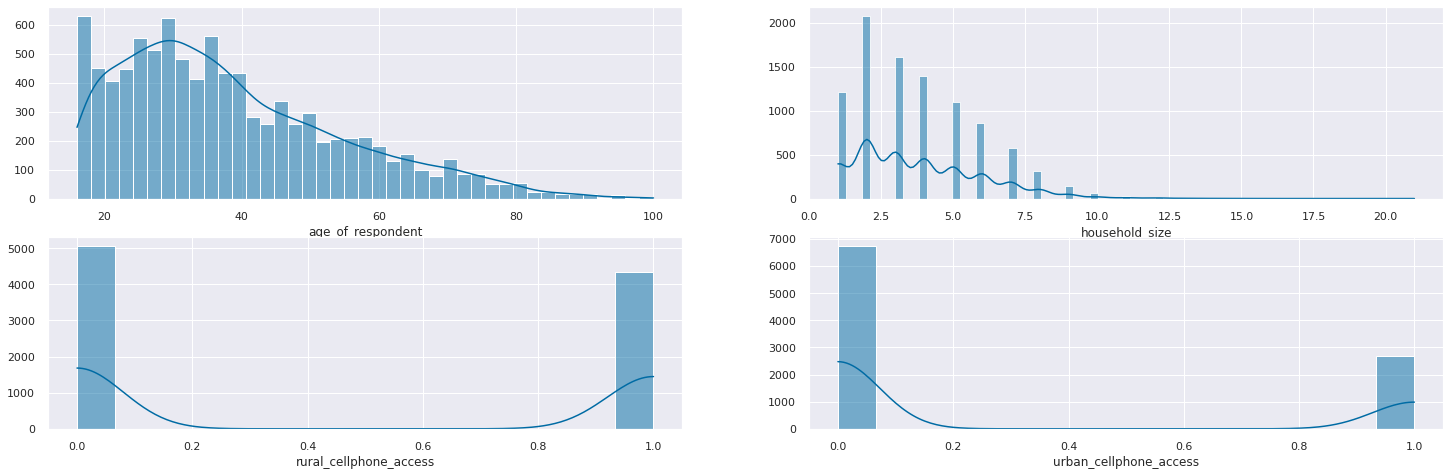

In [99]:
resc = X_train_imb.select_dtypes(include=['int64', 'float64'])
cols_drop = ['provedor']
resc = resc.drop(columns = cols_drop)
resc.columns

multiple_histplots(resc, 3, 2);

In [100]:
# Min-Max Scaler
mms = MinMaxScaler()

min_max_scaler = ['age_of_respondent', 'household_size']


for col in min_max_scaler:
    pickle.dump(mms, open(homepath + f'src/features/{col}_scaler.pkl', 'wb'))
    for dataframe in [X_train_imb, X_val]:
        dataframe[[col]] = mms.fit_transform(dataframe[[col]].values)

### 4.5 Encoding

In [101]:
# One Hot Encoding
X_train_imb, X_val = [pd.get_dummies(dataframe, prefix = ['idade'], columns = ['idade_categoria']) for dataframe in [X_train_imb, X_val]]

# Label Encoding
ohe = {'No': 0, 'Yes': 1}
gender_ohe = {'Male': 0, 'Female': 1}
location_ohe = {'Urban': 0, 'Rural': 1}

for dataframe in [X_train_imb, X_val]:
    dataframe['gender_of_respondent'] = dataframe['gender_of_respondent'].map(gender_ohe)
    dataframe['cellphone_access'] = dataframe['cellphone_access'].map(ohe)
    dataframe['location_type'] = dataframe['location_type'].map(location_ohe)

# Frequency Encoding
fe_cols = ['country', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

for col in fe_cols:
    fe_train, fe_val = [(dataframe.groupby(col).size())/len(dataframe) for dataframe in [X_train_imb, X_val]]
    X_train_imb.loc[:, col] = X_train_imb[col].map(fe_train)
    X_val.loc[:, col] = X_val[col].map(fe_val)

### 4.3 Balancing Target

Antes do balanceamento

In [102]:
y_train_imb.value_counts(normalize = True) * 100

0   85.705
1   14.295
Name: bank_account, dtype: float64

In [103]:
X_train_imb.head()

,country,gender_of_respondent,age_of_respondent,location_type,job_type,education_level,relationship_with_head,marital_status,household_size,cellphone_access,rural_cellphone_access,urban_cellphone_access,provedor,idade_adulto,idade_idoso,idade_jovem,idade_jovem_adulto,idade_meia_idade
7983,0.093,1,0.143,1,0.276,0.545,0.280,0.461,0.150,0,0,0,1,0,0,0,1,0
5386,0.367,0,0.476,1,0.232,0.034,0.538,0.461,0.450,1,1,0,1,0,0,0,0,1
11557,0.367,1,0.429,1,0.234,0.189,0.280,0.461,0.050,1,1,0,1,0,0,0,0,1
1660,0.367,0,0.143,1,0.232,0.545,0.538,0.461,0.150,1,1,0,1,0,0,0,1,0
1026,0.367,1,0.155,1,0.232,0.545,0.280,0.461,0.150,1,1,0,1,0,0,0,1,0


In [104]:
X_train_imb.columns

Index(['country', 'gender_of_respondent', 'age_of_respondent', 'location_type',
       'job_type', 'education_level', 'relationship_with_head',
       'marital_status', 'household_size', 'cellphone_access',
       'rural_cellphone_access', 'urban_cellphone_access', 'provedor',
       'idade_adulto', 'idade_idoso', 'idade_jovem', 'idade_jovem_adulto',
       'idade_meia_idade'],
      dtype='object')

In [105]:
synthetic_samples = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = 14)

X_train, y_train = synthetic_samples.fit_resample(X_train_imb, y_train_imb)

Após o balanceamento

In [106]:
y_train.value_counts(normalize = True) * 100

0   50.000
1   50.000
Name: bank_account, dtype: float64

### 4.6 Feature Importance

#### 4.6.1 Feature Importance with ExtraTrees

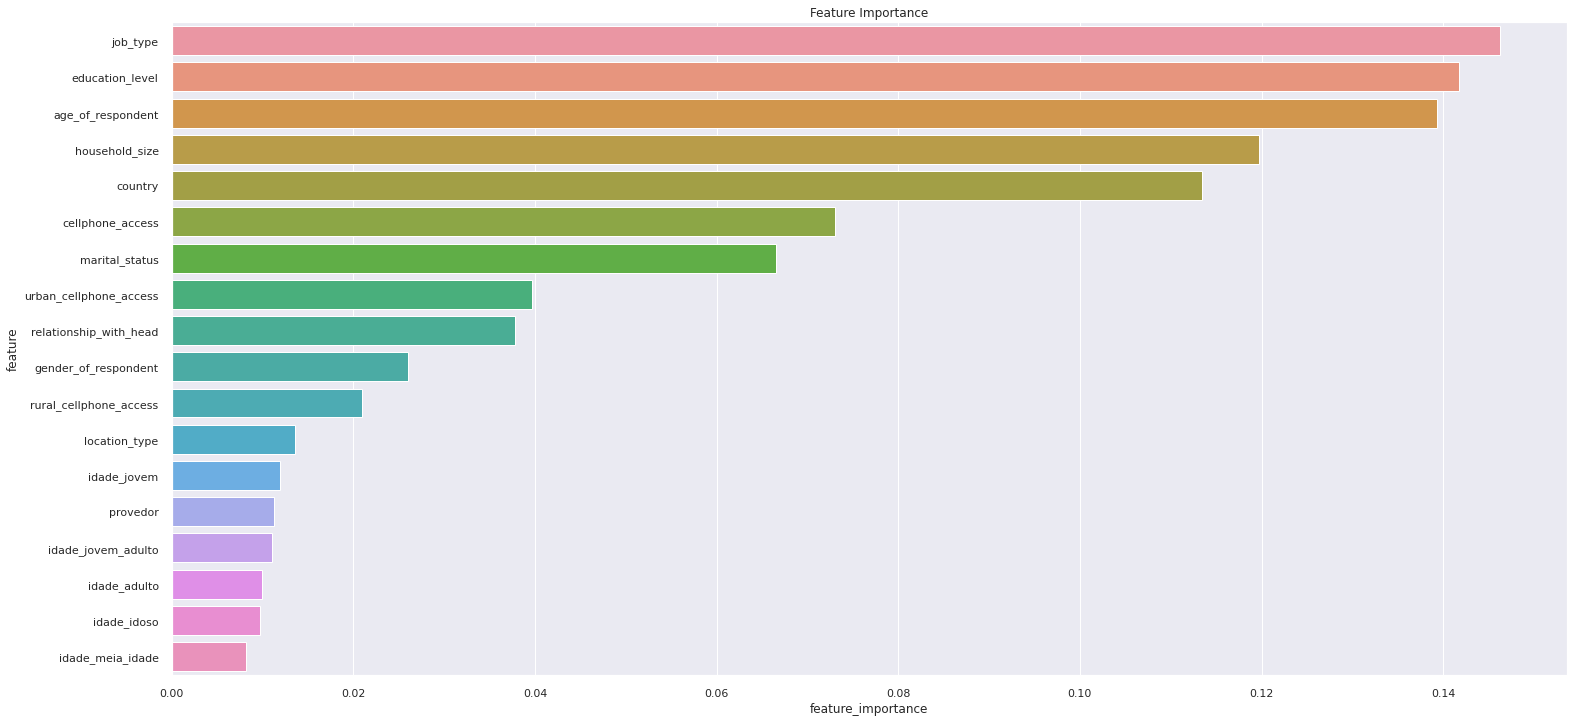

In [107]:
et_importance = ExtraTreesClassifier(n_estimators = 100, random_state = seed, n_jobs = 14)
et_importance.fit(X_train, y_train)

# feature importance dataframe
feature_selection = pd.DataFrame({'feature': X_train.columns,'feature_importance': et_importance.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

# plot feature importance
ax = sns.barplot(x = 'feature_importance', y = 'feature', data = feature_selection, orient = 'h')
ax.set_title('Feature Importance');

#### 4.6.2 Feature Importance with RFE

In [108]:
# feature selector
rf_selector = RandomForestClassifier(n_jobs = 14)
rfe = RFE(rf_selector, n_features_to_select = 8, step = 1)
rfe = rfe.fit(X_train, y_train)

# get ranking
rfe.support_

# selected columns
rfe_selected = X_train.loc[:, rfe.support_]
rfe_columns = rfe_selected.columns
rfe_columns

Index(['country', 'age_of_respondent', 'job_type', 'education_level',
       'relationship_with_head', 'marital_status', 'household_size',
       'cellphone_access'],
      dtype='object')

#### 4.6.3 Rank Features

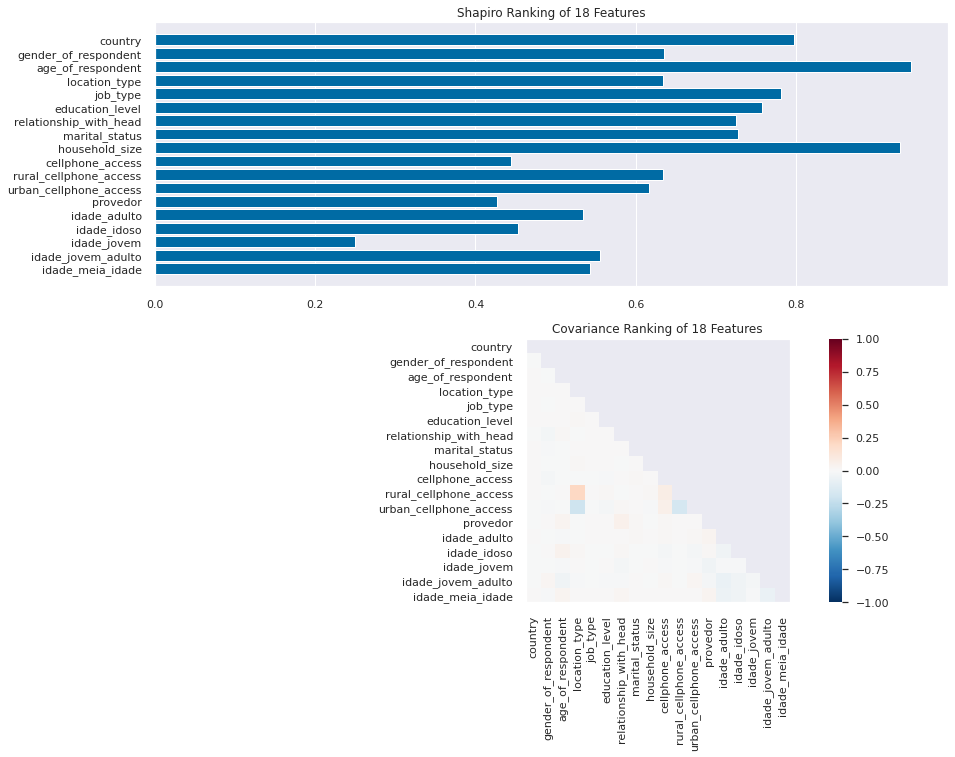

In [109]:
plt.subplot(2, 1, 1)
visualizer_1d = Rank1D(algorithm = 'shapiro', size = (1024, 768))
visualizer_1d.fit(X_train, y_train)           
visualizer_1d.transform(X_train)        
visualizer_1d.finalize();

plt.subplot(2, 1, 2)
visualizer_2d = Rank2D(algorithm='covariance', size = (1024, 768))
visualizer_2d.fit(X_train, y_train)
visualizer_2d.transform(X_train)
visualizer_2d.finalize();

#### 4.6.4 Boruta

In [110]:
rf_boruta = RandomForestClassifier(n_estimators = 500, n_jobs = 14, random_state = seed)

boruta = BorutaPy(rf_boruta, n_estimators = 'auto', random_state = seed).fit(X_train.values, y_train.values)

In [111]:
cols_selected = boruta.support_.tolist()

cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

In [112]:
cols_selected_boruta

['country',
 'age_of_respondent',
 'job_type',
 'education_level',
 'household_size',
 'cellphone_access']

In [113]:
cols_not_selected_boruta

['gender_of_respondent',
 'idade_adulto',
 'idade_idoso',
 'idade_jovem',
 'idade_jovem_adulto',
 'idade_meia_idade',
 'location_type',
 'marital_status',
 'provedor',
 'relationship_with_head',
 'rural_cellphone_access',
 'urban_cellphone_access']

### 4.7 Seleção de Features

In [114]:
cols_selected = ['country', 'age_of_respondent', 'job_type', 'education_level', 'marital_status', 'cellphone_access', 'household_size', 'relationship_with_head', 'gender_of_respondent']

X_train, X_val = [dataframe[cols_selected] for dataframe in [X_train, X_val]]

### 4.8 Save State

In [115]:
X_train.to_pickle(homepath + 'data/processed/X_train.pkl')
X_val.to_pickle(homepath + 'data/processed/X_val.pkl')
y_train.to_pickle(homepath + 'data/processed/y_train.pkl')
y_val.to_pickle(homepath + 'data/processed/y_val.pkl')
ids_train.to_pickle(homepath + 'data/processed/ids_train.pkl')
ids_val.to_pickle(homepath + 'data/processed/ids_val.pkl')

## 5. MACHINE LEARNING

### 5.1 Dataset Checkpoint

In [116]:
X_train = pd.read_pickle(homepath + 'data/processed/X_train.pkl')
X_val = pd.read_pickle(homepath + 'data/processed/X_val.pkl')
y_train = pd.read_pickle(homepath + 'data/processed/y_train.pkl')
y_val = pd.read_pickle(homepath + 'data/processed/y_val.pkl')

### 5.2 Modelos

In [117]:
models = [LogisticRegression(random_state = seed),
          RandomForestClassifier(random_state = seed, n_jobs = 14),
          ExtraTreesClassifier(random_state = seed, n_jobs = 14),
          GaussianNB(),
          XGBClassifier(random_state = seed, n_jobs = 14, eval_metric = 'logloss', use_label_encoder = False),
          CatBoostClassifier(random_state = seed, verbose = False),
          AdaBoostClassifier(random_state = seed),
          LGBMClassifier(random_state = seed, n_jobs = 14),
          KNeighborsClassifier(n_neighbors = 7, n_jobs = 14),
          GradientBoostingClassifier(random_state = seed)
         ]

In [118]:
metrics_result = metrics_result(models, 'bank_account', X_train, y_train, X_val, y_val)

Please, wait a moment - Doing ML
Training model 1/10 -> LogisticRegression
Training model 2/10 -> RandomForestClassifier
Training model 3/10 -> ExtraTreesClassifier
Training model 4/10 -> GaussianNB
Training model 5/10 -> XGBClassifier
Training model 6/10 -> CatBoostClassifier
Training model 7/10 -> AdaBoostClassifier
Training model 8/10 -> LGBMClassifier
Training model 9/10 -> KNeighborsClassifier
Training model 10/10 -> GradientBoostingClassifier
Finished, check the results


### 5.3 Cross_Validation

In [119]:
cv_result = cross_validation(models, 'bank_account', X_train, y_train)

Please, wait a moment, Doing CV
Folding model 1/10 -> LogisticRegression
Folding model 2/10 -> RandomForestClassifier
Folding model 3/10 -> ExtraTreesClassifier
Folding model 4/10 -> GaussianNB
Folding model 5/10 -> XGBClassifier
Folding model 6/10 -> CatBoostClassifier
Folding model 7/10 -> AdaBoostClassifier
Folding model 8/10 -> LGBMClassifier
Folding model 9/10 -> KNeighborsClassifier
Folding model 10/10 -> GradientBoostingClassifier
Finished, check the results


In [120]:
result = pd.merge(metrics_result, cv_result, on = 'Model_Name')

In [121]:
def highlight_max(s):
    # Only apply highlight in int and float
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: #F15854' if cell else '' for cell in is_max]

In [122]:
result.style.apply(highlight_max)

,Model_Name,Precision,Recall,F1 Score,ROCAUC,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,ROCAUC Mean,ROCAUC STD
0,LogisticRegression,0.273523,0.735294,0.398724,0.702719,0.692000,0.007000,0.723000,0.010000,0.707000,0.005000,0.701000,0.005000
1,RandomForestClassifier,0.177839,0.944118,0.299301,0.603455,0.812000,0.120000,0.818000,0.096000,0.815000,0.108000,0.812000,0.111000
2,ExtraTreesClassifier,0.222407,0.788235,0.346926,0.661380,0.850000,0.111000,0.854000,0.093000,0.852000,0.102000,0.850000,0.105000
3,GaussianNB,0.245462,0.835294,0.379426,0.700807,0.802000,0.128000,0.859000,0.081000,0.826000,0.099000,0.815000,0.110000
4,XGBClassifier,0.150576,1.000000,0.261740,0.523597,0.832000,0.130000,0.869000,0.075000,0.847000,0.098000,0.838000,0.109000
5,CatBoostClassifier,0.150000,0.997059,0.260769,0.521381,0.853000,0.127000,0.874000,0.070000,0.861000,0.094000,0.853000,0.105000
6,AdaBoostClassifier,0.190538,0.864706,0.312268,0.622119,0.857000,0.118000,0.870000,0.066000,0.861000,0.087000,0.855000,0.097000
7,LGBMClassifier,0.156453,0.991176,0.270249,0.544272,0.869000,0.115000,0.874000,0.062000,0.869000,0.084000,0.864000,0.094000
8,KNeighborsClassifier,0.319635,0.617647,0.421264,0.697795,0.861000,0.110000,0.874000,0.059000,0.865000,0.080000,0.860000,0.090000
9,GradientBoostingClassifier,0.152596,0.994118,0.264579,0.530839,0.868000,0.106000,0.875000,0.056000,0.869000,0.077000,0.865000,0.086000


## 6. HYPERPARAMETER FINE TUNNING

In [ ]:
X_train = pd.read_pickle(homepath + 'data/processed/X_train.pkl')
X_val = pd.read_pickle(homepath + 'data/processed/X_val.pkl')
y_train = pd.read_pickle(homepath + 'data/processed/y_train.pkl')
y_val = pd.read_pickle(homepath + 'data/processed/y_val.pkl')

In [ ]:
study_lgbm = optuna.create_study(direction = 'maximize', study_name = 'LGBM')
func = lambda trial: objective_lgbm(trial, X_train, y_train)
study_lgbm.optimize(func, n_trials = 70)

In [ ]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [ ]:
optuna.visualization.plot_param_importances(study_lgbm)

In [ ]:
print(f"\tBest value (log loss): {study_lgbm.best_value}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
models_opt = [
          LGBMClassifier(random_state = seed, n_jobs = -1),  
          LGBMClassifier(random_state = seed, n_jobs = -1, n_estimators = 800, learning_rate = 0.1049362242276428, num_leaves = 600, max_depth = 8)
         ]

In [ ]:
result = metrics_result(models_opt, 'bank_account', X_train, y_train, X_val, y_val)

In [ ]:
result

In [ ]:
cv_result_opt = cross_validation(models_opt, 'bank_account', X_train, y_train)

In [ ]:
cv_result_opt

In [ ]:
def data_preparation(data, cols_selected):
    """Return a dataframe with encoding, rescaling and drop
    Args:
        dataframe: [Dataframe without transformation]
        cols_selected: [Column with dropped features]

    Returns:
        [DataFrame]: [Prepared Dataframe]
    """

    #classificar relationship with head
    data['provedor'] = data['relationship_with_head'].apply(lambda x: 1 if (x == 'Head of Household') or (x == 'Spouse') else 0)

    # One Hot Encoding
    data = pd.get_dummies(data, prefix = ['idade'], columns = ['idade_categoria'])
    
    # Label Encoding
    ohe = {'No': 0, 'Yes': 1}
    gender_ohe = {'Male': 0, 'Female': 1}
    location_ohe = {'Urban': 0, 'Rural': 1}

    data['gender_of_respondent'] = data['gender_of_respondent'].map(gender_ohe)
    data['cellphone_access'] = data['cellphone_access'].map(ohe)
    data['bank_account'] = data['bank_account'].map(ohe)
    data['location_type'] = data['location_type'].map(location_ohe)

    # Frequency Encoding
    fe_cols = ['country', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

    for col in fe_cols:
        fe_encoding = (data.groupby(col).size())/len(data)
        data.loc[:, col] = data[col].map(fe_encoding)

    # Min-Max Scaler
    mms = MinMaxScaler()
    min_max_scaler = ['age_of_respondent']

    for col in min_max_scaler:
        data[[col]] = mms.fit_transform(data[[col]].values)

    # Columns
    data = data[cols_selected]

    return data

In [ ]:
# concat
df6 = pd.concat([x_train, x_val], ignore_index = True)
cols_selected = ['country', 'age_of_respondent', 'job_type', 'education_level', 'marital_status', 'cellphone_access', 'household_size', 'relationship_with_head', 'gender_of_respondent', 'bank_account']
df_final = data_preparation(df6, cols_selected)

# split
y_train_full = df_final['bank_account']
X_train_full = df_final.drop(columns = ['bank_account'])

# save pickle
X_train_full.to_pickle(homepath + 'data/processed/X_train_full.pkl')
y_train_full.to_pickle(homepath + 'data/processed/y_train_full.pkl')

In [ ]:
X_train_full.info()

In [ ]:
	n_estimators: 1300
		learning_rate: 0.25757053371903266
		num_leaves: 2100
		max_depth: 11

In [ ]:
final_model = LGBMClassifier(random_state = seed, n_jobs = -1, n_estimators = 1300, num_leaves = 2100, max_depth = 11)
final_model.fit(X_train, y_train)
pickle.dump(final_model, open(homepath + '/models/hackday', 'wb'))

In [ ]:
import scikitplot as skplt

In [ ]:
y_hat = final_model.predict_proba(X_val)
skplt.metrics.plot_ks_statistic(y_val, y_hat)